In [1]:
import pandas as pd
import networkx as nx
import os

In [2]:
import random
random.seed(246)

In [3]:
files = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network_list.csv'))
files.NUMBER_OF_PARTICIPANTS.value_counts(normalize=True)
# Just to check that the modularity classes does not coincide with the number of 
# opponents since that provides a lot of information about the game (about the zeros)
# It indeed does not coincide, so the modularity classes are meaningful
# Gephi shows: 35.03%, 25.72%, 25.72% and 13.53%

NUMBER_OF_PARTICIPANTS
8    0.467742
7    0.370968
6    0.129032
5    0.032258
Name: proportion, dtype: float64

In [4]:
players_graph = nx.read_gml(os.path.join('comm-f2f-Resistance', 'embeddings.gml'))

In [5]:
communities = nx.community.greedy_modularity_communities(players_graph, weight='weight', resolution=1.02)
len(communities)

3

In [6]:
[len(community) for community in communities]

[216, 202, 33]

In [8]:
node_color = {}
node_community = {}
community_color = {
    0: 'orange',
    1: 'cyan',
    2: 'magenta'
}
for node in players_graph.nodes():
    for i, community in enumerate(communities):
        if node in community:
            node_color[node] = community_color[i]
            node_community[node] = i
            break

In [9]:
players_graph.nodes()

NodeView(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


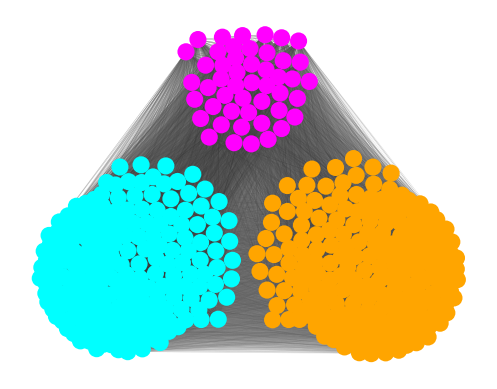

In [12]:
import matplotlib.pyplot as plt
from netgraph import Graph
fig, ax = plt.subplots()
Graph(
    players_graph,
    node_color=node_color, 
    node_edge_width=0,     
    edge_width=0.1,          
    edge_alpha=0.5,        
    node_layout='community',
    node_layout_kwargs=dict(node_to_community=node_community),
    #edge_layout='bundled',
    ax=ax,
)

In [7]:
files = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network_list.csv'))
games = []
for index, data in files.iterrows():
    game = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network', f'network{index}_weighted.csv'))
    cols_to_drop = ['TIME']
    cols_to_drop.extend(game.columns[game.columns.str.match(r'P._TO_LAPTOP')])
    game.drop(columns=cols_to_drop, inplace=True)
    conv = game.rolling(window=5).mean().dropna().reset_index(drop=True)
    games.append(conv)
games

[      P1_TO_P1  P1_TO_P2  P1_TO_P3  P1_TO_P4  P1_TO_P5  P1_TO_P6  P1_TO_P7  \
 0          0.0    0.0606    0.1240    0.0026    0.0488    0.0296    0.0810   
 1          0.0    0.0676    0.1394    0.0038    0.0540    0.0324    0.1164   
 2          0.0    0.0812    0.1630    0.0056    0.0674    0.0418    0.1796   
 3          0.0    0.0944    0.1846    0.0066    0.0786    0.0496    0.2636   
 4          0.0    0.1020    0.1856    0.0066    0.0874    0.0564    0.3438   
 ...        ...       ...       ...       ...       ...       ...       ...   
 7314       0.0    0.0944    0.3762    0.0000    0.1628    0.0098    0.3472   
 7315       0.0    0.0840    0.3324    0.0000    0.1374    0.0076    0.4314   
 7316       0.0    0.0774    0.3226    0.0000    0.1296    0.0074    0.4586   
 7317       0.0    0.0674    0.2792    0.0000    0.1068    0.0048    0.5400   
 7318       0.0    0.0764    0.2708    0.0002    0.1050    0.0092    0.5332   
 
       P2_TO_P1  P2_TO_P2  P2_TO_P3  ...  P6_TO_P5

In [8]:
from math import sqrt
def create_graph_instance(row: pd.Series) -> nx.Graph:
    """Create a graph representing a moment in the game."""
    players = round(sqrt(len(conv.iloc[0])))
    matrix = conv.iloc[0].values.reshape(-1, players)
    return nx.Graph(matrix)

from typing import Callable
# Python 3.12+ for the generic T, otherwise use:
# def calculate_metric(row: pd.Series, *, metric):
def calculate_metric[T](row: pd.Series, *, metric: Callable[[nx.Graph], T]) -> T:
    G = create_graph_instance(row)
    return metric(G)

def return_true(row):
    return True

example_conv = games[0]
example_conv.apply(calculate_metric, axis=1, metric=return_true)

0       True
1       True
2       True
3       True
4       True
        ... 
7314    True
7315    True
7316    True
7317    True
7318    True
Length: 7319, dtype: bool

In [9]:
def extract_features(row):
    G = create_graph_instance(row)
    return pd.Series({
        'density': nx.density(G),
        'avg_degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
        'clustering': nx.average_clustering(G),
    })

example_conv.apply(extract_features, axis=1)


,density,avg_degree,clustering
0,1.0,7.0,1.0
1,1.0,7.0,1.0
2,1.0,7.0,1.0
3,1.0,7.0,1.0
4,1.0,7.0,1.0
...,...,...,...
7314,1.0,7.0,1.0
7315,1.0,7.0,1.0
7316,1.0,7.0,1.0
7317,1.0,7.0,1.0


<Axes: >

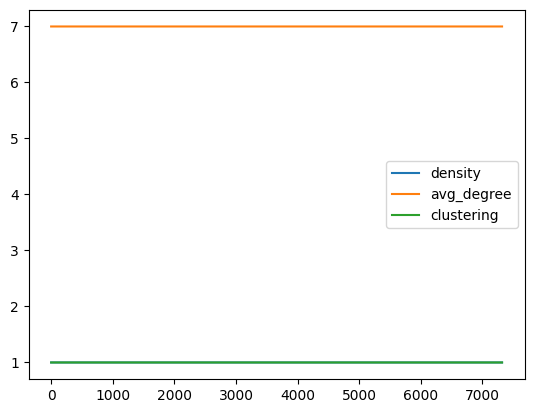

In [10]:
metrics = example_conv.apply(extract_features, axis=1)
metrics.plot()

In [12]:
def create_graph_instance(row: pd.Series) -> nx.Graph:
    """Create a graph representing a moment in the game."""
    players = round(sqrt(len(row)))
    matrix = row.values.reshape(players, players)
    return nx.Graph(matrix)

<Axes: >

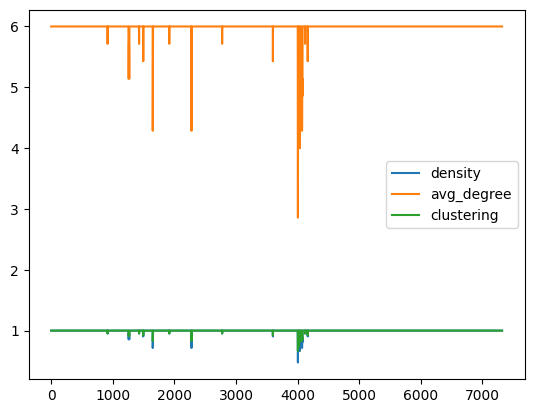

In [13]:
metrics = example_conv.apply(extract_features, axis=1)
metrics.plot()

In [11]:
degrees_all_games = []

for index, row in files.iterrows():
    game_path = os.path.join('comm-f2f-Resistance', 'network', f'network{index}_weighted.csv')
    game_df = pd.read_csv(game_path)

    cols_to_drop = ['TIME'] + list(game_df.columns[game_df.columns.str.contains('TO_LAPTOP')])
    game_df = game_df.drop(columns=cols_to_drop)

    smoothed = game_df.rolling(window=5).mean().dropna().reset_index(drop=True)
    n_players = int(sqrt(len(smoothed.columns)))
    
    for t, row in smoothed.iterrows():
        matrix = row.values.reshape(n_players, n_players)

        # ponderado
        G_weighted = nx.from_numpy_array(matrix)

        # no ponderado
        G_binary = nx.from_numpy_array((matrix > 0).astype(int))

        # métricas por jugador
        for node in G_weighted.nodes():
            degrees_all_games.append({
                'game_index': index,
                'frame': t,
                'player': node,
                'degree_weighted': G_weighted.degree(node, weight='weight'),
                'degree_unweighted': G_binary.degree(node)
            })


degrees_df = pd.DataFrame(degrees_all_games)
degrees_df.head()

,game_index,frame,player,degree_weighted,degree_unweighted
0,0,0,0,0.3066,6
1,0,0,1,0.6496,6
2,0,0,2,0.9542,6
3,0,0,3,0.2764,6
4,0,0,4,0.8778,6


In [ ]:
degrees_df
# Podríamos sacar de aqui jugadores que miran mucho pero que reciben poca atención

,game_index,frame,player,degree_weighted,degree_unweighted
0,0,0,0,0.3066,6
1,0,0,1,0.6496,6
2,0,0,2,0.9542,6
3,0,0,3,0.2764,6
4,0,0,4,0.8778,6
...,...,...,...,...,...
3125184,61,8494,3,1.1264,7
3125185,61,8494,4,0.7112,7
3125186,61,8494,5,1.5764,7
3125187,61,8494,6,0.7410,7


In [15]:
# grado total ponderado para cada jugador
degree_weighted_totals = degrees_df.groupby('player')['degree_weighted'].sum()

# grado total no ponderado para cada jugador
degree_unweighted_totals = degrees_df.groupby('player')['degree_unweighted'].sum()

# Jugador más sociable
most_sociable_weighted = degree_weighted_totals.idxmax()
most_sociable_weighted_degree = degree_weighted_totals.max()

# Jugador menos sociable
least_sociable_weighted = degree_weighted_totals.idxmin()
least_sociable_weighted_degree = degree_weighted_totals.min()

# Jugador más sociable (no ponderado)
most_sociable_unweighted = degree_unweighted_totals.idxmax()
most_sociable_unweighted_degree = degree_unweighted_totals.max()

# Jugador menos sociable (no ponderado)
least_sociable_unweighted = degree_unweighted_totals.idxmin()
least_sociable_unweighted_degree = degree_unweighted_totals.min()

# Mostrar los resultados
print(f"Jugador más sociable (ponderado): Jugador {most_sociable_weighted} con grado {most_sociable_weighted_degree}")
print(f"Jugador menos sociable (ponderado): Jugador {least_sociable_weighted} con grado {least_sociable_weighted_degree}")
print(f"Jugador más sociable (no ponderado): Jugador {most_sociable_unweighted} con grado {most_sociable_unweighted_degree}")
print(f"Jugador menos sociable (no ponderado): Jugador {least_sociable_unweighted} con grado {least_sociable_unweighted_degree}")


Jugador más sociable (ponderado): Jugador 3 con grado 410922.6104
Jugador menos sociable (ponderado): Jugador 7 con grado 206340.702
Jugador más sociable (no ponderado): Jugador 3 con grado 2698742
Jugador menos sociable (no ponderado): Jugador 7 con grado 1544099


In [16]:
betweenness = nx.betweenness_centrality(G_weighted, weight='weight')

betweenness_df = pd.DataFrame.from_dict(betweenness, orient='index', columns=['betweenness'])
betweenness_df['player'] = betweenness_df.index

betweenness_df
# O algo está mal o esto significaría que hay muchos jugadores que no son relevantes para la conexión o intermediación entre
# jugadores en la partida, mientras que uno es muy importante.

,betweenness,player
0,0.000000,0
1,0.238095,1
2,0.380952,2
3,0.142857,3
4,0.000000,4
5,0.000000,5
6,0.000000,6
7,0.000000,7


In [17]:
# Lo mismo que para grados pero con betweenness para ver si hay fallo

betweenness_all_games = []

for index, row in files.iterrows():
    game_path = os.path.join('comm-f2f-Resistance', 'network', f'network{index}_weighted.csv')
    game_df = pd.read_csv(game_path)

    cols_to_drop = ['TIME'] + list(game_df.columns[game_df.columns.str.contains('TO_LAPTOP')])
    game_df = game_df.drop(columns=cols_to_drop)

    smoothed = game_df.rolling(window=5).mean().dropna().reset_index(drop=True)
    n_players = int(sqrt(len(smoothed.columns)))
    
    for t, row in smoothed.iterrows():
        matrix = row.values.reshape(n_players, n_players)

        G_weighted = nx.from_numpy_array(matrix)
        
        betweenness_weighted = nx.betweenness_centrality(G_weighted, weight='weight')

        for node in G_weighted.nodes():
            betweenness_all_games.append({
                'game_index': index,
                'frame': t,
                'player': node,
                'betweenness_weighted': betweenness_weighted.get(node, 0),
            })

betweenness_df = pd.DataFrame(betweenness_all_games)
betweenness_df.head()


,game_index,frame,player,betweenness_weighted
0,0,0,0,0.200000
1,0,0,1,0.066667
2,0,0,2,0.000000
3,0,0,3,0.400000
4,0,0,4,0.000000


In [25]:
betweenness_df

,game_index,frame,player,betweenness_weighted
0,0,0,0,0.200000
1,0,0,1,0.066667
2,0,0,2,0.000000
3,0,0,3,0.400000
4,0,0,4,0.000000
...,...,...,...,...
3125184,61,8494,3,0.142857
3125185,61,8494,4,0.000000
3125186,61,8494,5,0.000000
3125187,61,8494,6,0.000000


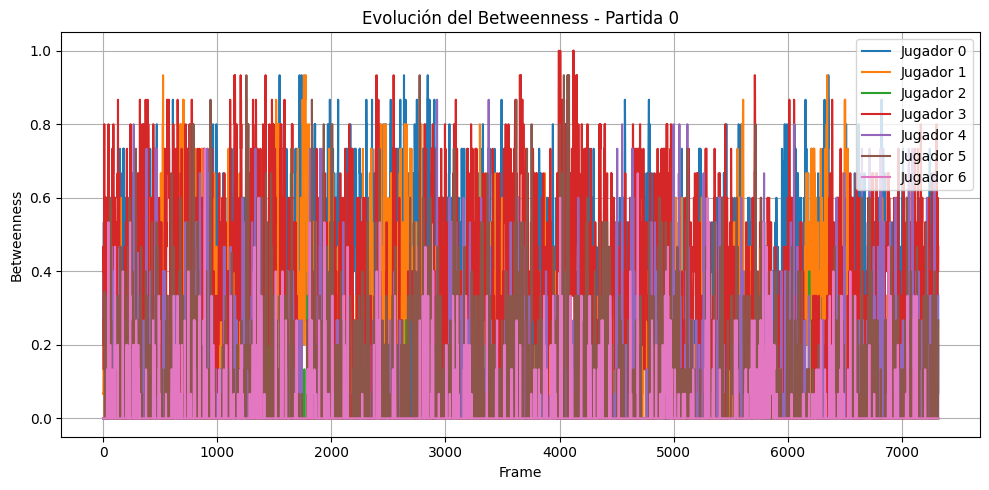

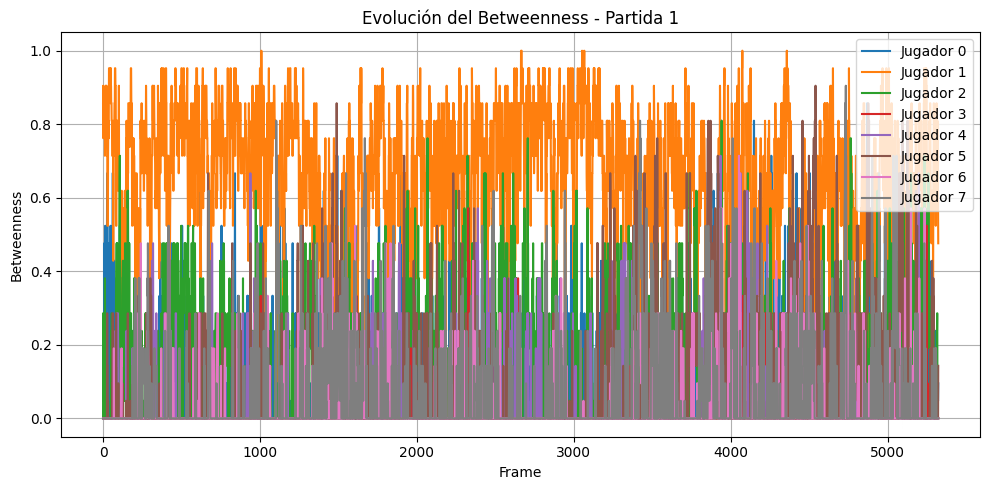

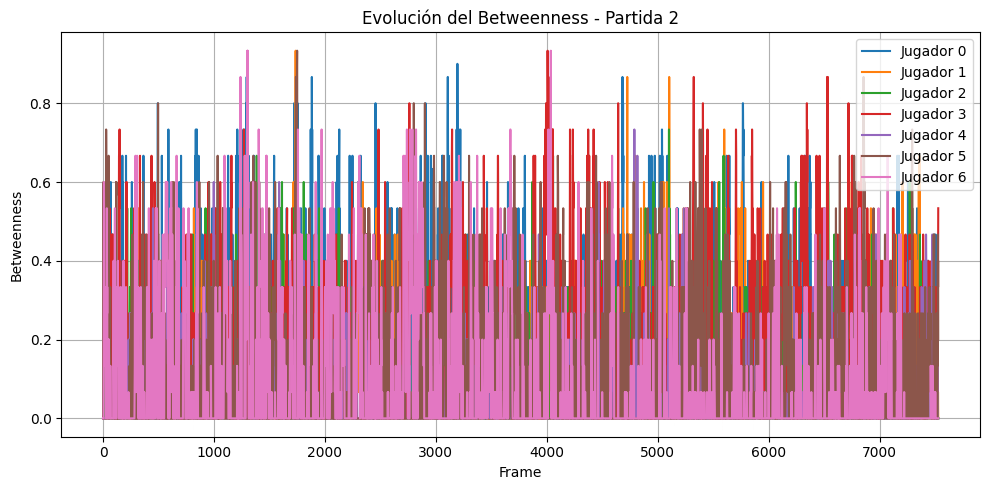

In [26]:
import matplotlib.pyplot as plt

games = betweenness_df['game_index'].unique()

for game_id in games[:3]:
    df_game = betweenness_df[betweenness_df['game_index'] == game_id]

    plt.figure(figsize=(10, 5))
    
    for player in sorted(df_game['player'].unique()):
        df_player = df_game[df_game['player'] == player]
        plt.plot(df_player['frame'], df_player['betweenness_weighted'], label=f'Jugador {player}')
    
    plt.title(f'Evolución del Betweenness - Partida {game_id}')
    plt.xlabel('Frame')
    plt.ylabel('Betweenness')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

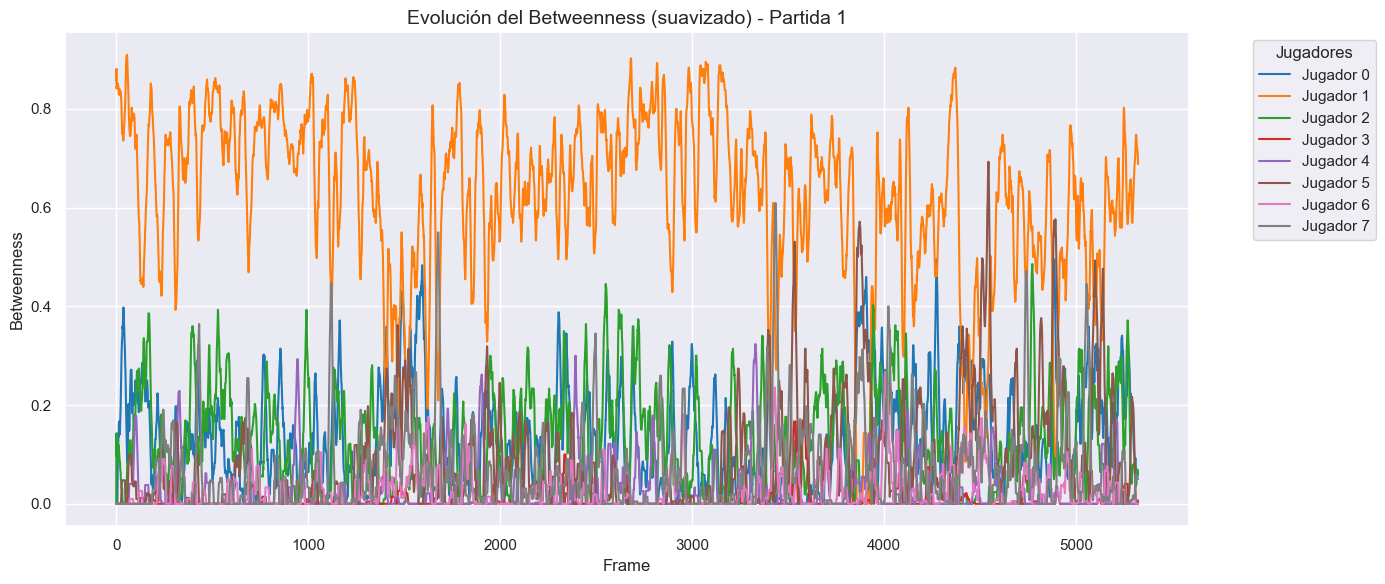

In [28]:
# Copilot para intentar suavizar


import seaborn as sns

# Parámetros
window = 20  # Número de frames para suavizar
game_id = 1  # Cambia este número para ver otra partida

# Filtrar la partida
df_game = betweenness_df[betweenness_df['game_index'] == game_id].copy()

# Aplicar suavizado por jugador
df_game['betweenness_smoothed'] = df_game.groupby('player')['betweenness_weighted'].transform(
    lambda x: x.rolling(window=window, min_periods=1).mean()
)

# Configuración visual
sns.set(style="darkgrid", context='notebook')
plt.figure(figsize=(14, 6))

# Colores únicos
palette = sns.color_palette("tab10", n_colors=df_game['player'].nunique())

# Graficar líneas suavizadas
for i, (player, df_player) in enumerate(df_game.groupby('player')):
    plt.plot(df_player['frame'], df_player['betweenness_smoothed'], label=f'Jugador {player}', color=palette[i])

# Estética
plt.title(f'Evolución del Betweenness (suavizado) - Partida {game_id}', fontsize=14)
plt.xlabel('Frame')
plt.ylabel('Betweenness')
plt.legend(title='Jugadores', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [33]:
# Social players tend to interact with other social players?
# Creo que el problema está en la diagonal de 0 en las similaridades con uno mismo

import numpy as np

G = nx.read_gml('comm-f2f-Resistance/embeddings.gml')
similarities = np.array(nx.to_numpy_array(G))

threshold = 0.5
social_interactions = similarities > threshold

degrees = np.array([G.degree(node) for node in G.nodes()])

# Filtrar los jugadores más sociales (mayor grado)
threshold_degree = np.percentile(degrees, 75)  # ejemplo, jugadores con grado en el percentil 75
social_players = [node for node, deg in zip(G.nodes(), degrees) if deg > threshold_degree]

social_player_interactions = social_interactions[np.ix_(social_players, social_players)]

# porcentaje de interacciones sociales dentro del grupo de jugadores más sociales
interaction_ratio = np.sum(social_player_interactions) / (len(social_players) * (len(social_players) - 1))
print(f"El porcentaje de interacciones entre los jugadores más sociales es: {interaction_ratio:.2f}")


El porcentaje de interacciones entre los jugadores más sociales es: nan


/var/folders/05/6jmrnggx2x14zbdvgbyf1zqh0000gn/T/ipykernel_32686/4129913675.py:21: RuntimeWarning: invalid value encountered in scalar divide
  interaction_ratio = np.sum(social_player_interactions) / (len(social_players) * (len(social_players) - 1))


In [ ]:
# Los cliques no creo que tengan mucho sentido porque seguramente participen todos con todos en las partidas
# y más aún en el total del juego.

In [ ]:
# Copilot

# Crear el grafo acumulado para un juego completo
def create_cumulative_graph(game_df: pd.DataFrame) -> nx.Graph:
    """Crea un grafo acumulado para un juego completo."""
    # Inicializar el grafo vacío
    G_cumulative = nx.Graph()

    # Agregar cada momento del juego (frame) al grafo acumulado
    for t, row in game_df.iterrows():
        matrix = row.values.reshape(int(sqrt(len(row))), -1)
        G_frame = nx.from_numpy_array(matrix)
        
        # Agregar las aristas de este frame al grafo acumulado
        G_cumulative = nx.compose(G_cumulative, G_frame)  # Combinamos el grafo actual con el acumulado
    
    return G_cumulative

# Calcular los cliques en el grafo acumulado
def calculate_cliques_for_game(game_df: pd.DataFrame) -> list:
    """Calcula los cliques para un juego completo, no por frame."""
    G_cumulative = create_cumulative_graph(game_df)
    cliques = list(nx.find_cliques(G_cumulative))  # Encuentra todos los cliques en el grafo acumulado
    return cliques

# Procesar todos los juegos
cliques_all_games = []
for index, game_df in enumerate(games):
    cliques = calculate_cliques_for_game(game_df)
    for clique in cliques:
        cliques_all_games.append({
            'game_index': index,
            'clique_size': len(clique),
            'clique': clique
        })

cliques_df = pd.DataFrame(cliques_all_games)
print(cliques_df.head())

   game_index  clique_size                    clique
0           0            7     [0, 1, 2, 3, 4, 5, 6]
1           1            8  [0, 1, 2, 3, 4, 5, 6, 7]
2           2            7     [0, 1, 2, 3, 4, 5, 6]
3           3            7     [0, 1, 2, 3, 4, 5, 6]
4           4            8  [0, 1, 2, 3, 4, 5, 6, 7]
